In [ ]:
# JD: -10 for missing FN in compute_pr
# JD: -10 for incorrect area calculation in compute_roc_curve

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load the data
health_data=pd.read_csv('healthcare-dataset-stroke-data.csv') # csv file must be in the same directory as the notebook

# We need to perform some preprocessing to remove missing values and encode categorical variables
impute= SimpleImputer(missing_values=np.nan, strategy='median')
health_data['bmi']=pd.DataFrame(impute.fit_transform(np.array(health_data['bmi']).reshape(-1, 1)))
OH=OneHotEncoder()
for col in health_data.select_dtypes(include=['object']):
  health_data[col]=OH.fit_transform(health_data[[col]]).toarray()

# Separate the features and the target
X = health_data.drop('stroke', axis=1).values  # features
y = health_data['stroke'].values # targets

# Scale the features to have zero mean and unit variance -- this helps gradient descent converge faster
X = StandardScaler().fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Generate the predicted _probabilities_ on the test set
y_pred_probs = clf.predict_proba(X_test)[:, 1]  # probability of the positive class

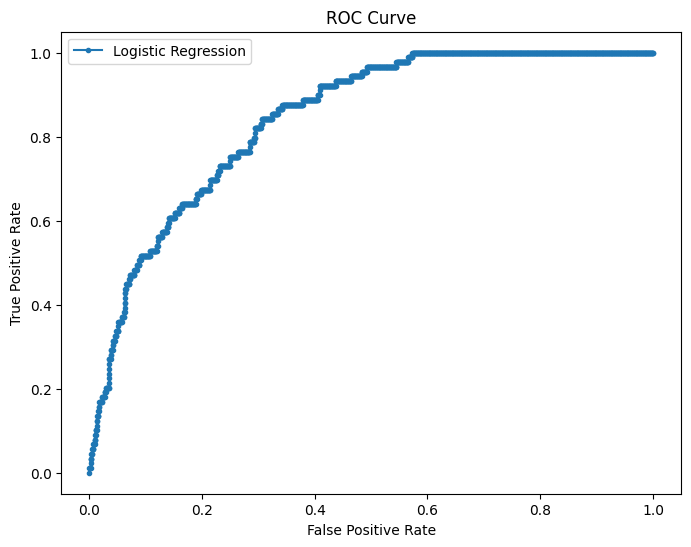

AUC: 0.8429456254474151


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_13993/3231889684.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sorted_tpr, sorted_fpr)


In [6]:
# ROC Curve construction and AUC calculation

# Function to compute TPR, FPR, TNR, FNR
def compute_rates(y_true, y_probs, threshold):
    """
    Compute tpr, fpr, tnr, and fnr for a single threshold value
    """
    y_pred = (y_probs >= threshold).astype(int)
    
    ## Compute the number of true positives, false positives, true negatives, and false negatives ##
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    ## Compute the true positive rate (TPR), false positive rate (FPR), true negative rate (TNR), and false negative rate (FNR) ##
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    ## return the list specified by the docstring ##
    return [TPR, FPR, TNR, FNR]

# Compute ROC Curve
def compute_roc_curve(y_true, y_probs):
    """
    Compute TPR and FPR for varying threshold values
    """
    thresholds = np.sort(np.unique(y_probs))
    tpr_list, fpr_list = [], []
    
    ## Populate tpr_list and fpr_list here ##
    for threshold in thresholds:
        tpr, fpr, _, _ = compute_rates(y_true, y_probs, threshold)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return tpr_list, fpr_list

## Call the compute_roc_curve function and store the results in tpr and fpr ##
tpr, fpr = compute_roc_curve(y_test, y_pred_probs)

## Plot ROC Curve ##
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Compute AUC using trapezoidal rule and print out the result ##
sorted_fpr = np.sort(fpr)
sorted_tpr = [x for _, x in sorted(zip(fpr, tpr))]

auc = np.trapz(sorted_tpr, sorted_fpr)
print(f'AUC: {auc}')

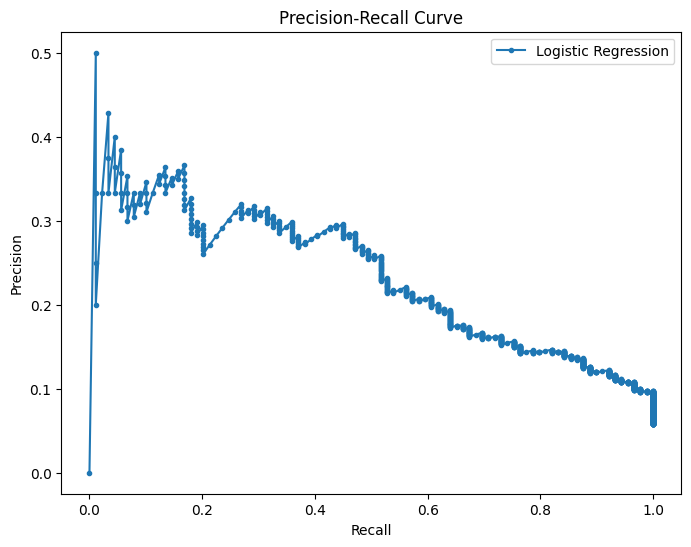

Average Precision: -0.23221253495899302


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_13993/2562496398.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  average_precision = np.trapz(precision, recall)


In [9]:
# Precision Recall Curve construction and Average Precision calculation

#def compute_pr(y_true, y_probs, threshold):
def compute_pr(y_true, y_probs, threshold):
    """
    Compute precision and recall for a single threshold value
    """
    y_pred = (y_probs >= threshold).astype(int)
    
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    
    # JD ADDED
    FN = np.sum((y_pred == 0) & (y_true == 1))
    #
    
    ## Compute precision ##
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    ## Compute recall ##
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

def compute_pr_curve(y_true, y_probs):
    """
    Compute precision and recall for varying threshold values
    """
    thresholds = np.sort(np.unique(y_probs))
    precision_list, recall_list = [], []

    ## populate precision_list and recall_list here ##
    for threshold in thresholds:
        precision, recall = compute_pr(y_true, y_probs, threshold)
        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list

## Call the compute_pr_curve function and store the results ##
precision, recall = compute_pr_curve(y_test, y_pred_probs)

## Plot Precision-Recall Curve ##
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Compute average precision and report the result ##
average_precision = np.trapz(precision, recall)
print(f'Average Precision: {average_precision}')

In [ ]:

# Compare your answers with the sklearn implementation

from sklearn.metrics import roc_auc_score, average_precision_score

## Call the roc_auc_score and average_precision_score functions from scikit-learn your data ##
auc_sklearn = roc_auc_score(y_test, y_pred_probs)
average_precision_sklearn = average_precision_score(y_test, y_pred_probs)

## Print out the results ##
print(f'Scikit-learn AUC: {auc_sklearn}')
print(f'Scikit-learn Average Precision: {average_precision_sklearn}')